# Limpieza y el preprocesamiento de los datos



In [1]:
import pandas as pd

# Defino los paths de los archivos Excel
pipomessage_path = "tecnica_diego/obscure_pipomessage.xlsx"
user_path = "tecnica_diego/obscure_user.xlsx"
usermessage_path = "tecnica_diego/usermessage.xlsx"
symptoms_path = "tecnica_diego/obscure_symptoms.xlsx"

# Cargar los datos en pandas DataFrames
pipomessage_df = pd.read_excel(pipomessage_path)
user_df = pd.read_excel(user_path)
usermessage_df = pd.read_excel(usermessage_path)
symptoms_df = pd.read_excel(symptoms_path)

Comenzaremos con la limpieza de los valores de intensidad de los síntomas. Asumimos que cualquier valor por encima de 10 es un error de entrada y debería haber sido 10. Entonces reemplazaremos estos valores con 10

In [2]:
symptoms_df.loc[symptoms_df['intensity'] > 10, 'intensity'] = 10

# Verificamos
symptoms_df['intensity'].value_counts().sort_index()

intensity
0.0      19
1.0      80
2.0     355
3.0     527
4.0     461
5.0     652
6.0     483
7.0     523
8.0     617
9.0     294
10.0    290
Name: count, dtype: int64

# Valores faltantes
'cancer_type': Esta informacion solo se registra una sola vez. Entonces, la ausencia de un valor podría indicar que no se conoce el tipo de cáncer del usuario, por lo que podríamos reemplazar los valores faltantes con "Desconocido"

'body' de la tabla de mensajes de PIPO y de USER:  Vamos a eliminar las filas con mensajes faltantes, ya que es difícil imputar los mensajes

'intensity' de la tabla de registro de sintomas: Vamos a llenar los valores faltantes con la mediana, para preservar la distribución de los datos

In [3]:
from sklearn.impute import SimpleImputer
import emoji

def contains_emoji(string): 
     """Returns True if the string is an emoji.""" 
     return emoji.is_emoji(string)

# Reemplazo los canceres faltantes con 'Desconocido'
user_df['cancer_type'].fillna('Desconocido', inplace=True)

# Eliminamos las filas con mensajes vacios y que no contengan emojis
pipomessage_df['contains_emoji'] = pipomessage_df['body'].apply(contains_emoji)
pipomessage_df = pipomessage_df[~pipomessage_df['body'].isna() | pipomessage_df['contains_emoji']]

usermessage_df['contains_emoji'] = usermessage_df['body'].apply(contains_emoji)
usermessage_df = usermessage_df[~usermessage_df['body'].isna() | usermessage_df['contains_emoji']]

# Intensidades faltantes con la mediana del dataset
imputer = SimpleImputer(strategy='median')
symptoms_df['intensity'] = imputer.fit_transform(symptoms_df[['intensity']])

# Pasamos a minusculas los mensajes para posterior tratamiento
pipomessage_df['body'] = pipomessage_df['body'].str.lower()
usermessage_df['body'] = usermessage_df['body'].str.lower()

# Verificamos
user_df.isnull().sum(), pipomessage_df.isnull().sum(), usermessage_df.isnull().sum(), symptoms_df.isnull().sum()


(phone_number     0
 creation_date    0
 cancer_type      0
 dtype: int64,
 id                0
 patient           0
 creation_date     0
 body              6
 contains_emoji    0
 dtype: int64,
 id                    0
 patient               1
 creation_date         0
 body               4534
 local_time        25080
 contains_emoji        0
 dtype: int64,
 id               0
 user             0
 creation_date    0
 description      0
 intensity        0
 dtype: int64)

Vamos a estandarizar los datos de texto correspondiente al tipo de cancer y sintomas debido a lo visto en el analisis exploratorio. Esto implicará convertir el texto a minúsculas y eliminar la puntuación, caracteres especiales y espacios en blanco extra.

In [5]:
import unicodedata
def remove_accents(input_str):
    if isinstance(input_str, str):
        nfkd_form = unicodedata.normalize('NFKD', input_str)
        return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])
    else:
        return input_str

# Tipo de cancer
user_df['cancer_type'] = user_df['cancer_type'].str.lower()
user_df['cancer_type'] = user_df['cancer_type'].apply(remove_accents)
user_df['cancer_type'] = user_df['cancer_type'].str.strip('.').str.lower()

# Sintomas
symptoms_df['description'] = symptoms_df['description'].str.lower()
symptoms_df['description'] = symptoms_df['description'].apply(remove_accents)

user_df.head(), symptoms_df.head()

(     phone_number                     creation_date     cancer_type
 0    883888159324         2022-10-17 14:12:55+00:00     desconocido
 1    883801795941  2023-01-31 13:08:09.590326+00:00  cancer de mama
 2    882996887778  2023-01-31 13:30:22.994697+00:00     desconocido
 3    882872325922  2023-02-14 16:03:56.272810+00:00     desconocido
 4  93349800196016         2022-11-21 14:28:46+00:00     desconocido,
      id            user                     creation_date       description  \
 0  4167  88731763329655  2023-02-15 18:00:53.236432+00:00    dolor corporal   
 1  4018    883388003973  2023-02-11 16:46:47.550859+00:00  dolor de cintura   
 2  6019   9932141828978  2023-04-01 13:51:47.517999+00:00         cansancio   
 3     5    883140979880  2023-01-12 13:47:12.678250+00:00   dolor de cabeza   
 4     4  88616265413822  2023-01-12 13:26:54.762139+00:00   dolor de cabeza   
 
    intensity  
 0        6.0  
 1        6.0  
 2        6.0  
 3       10.0  
 4        5.0  )

### Recrearemos las graficas del analisis exploratorio con los nuevos datasets

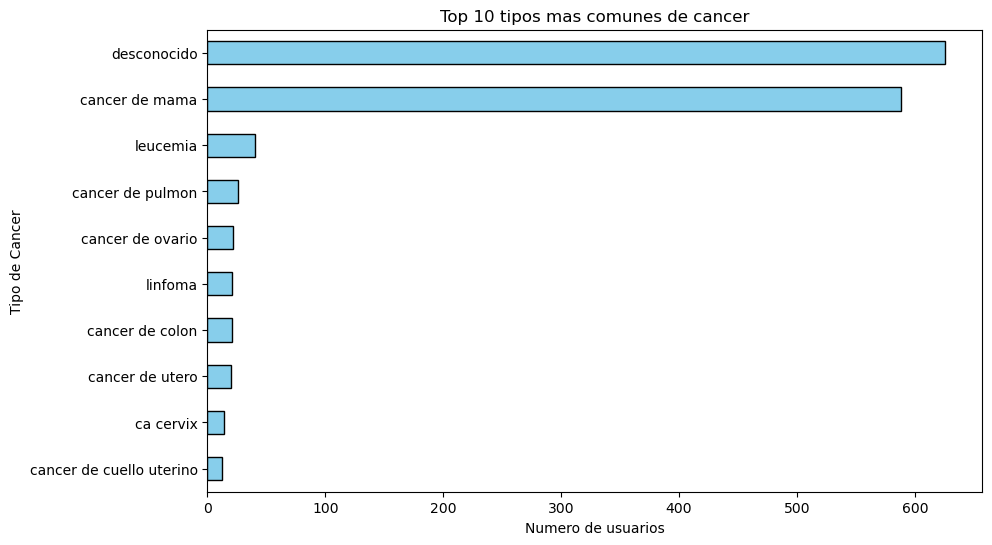

In [6]:
import matplotlib.pyplot as plt
# Contemos cada tipo de cancer
cancer_type_counts = user_df['cancer_type'].value_counts()

# Grafiquemos los 10 tipos mas comunes
plt.figure(figsize=(10, 6))
cancer_type_counts[:10].plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 10 tipos mas comunes de cancer')
plt.xlabel('Numero de usuarios')
plt.ylabel('Tipo de Cancer')
plt.gca().invert_yaxis()
plt.show()

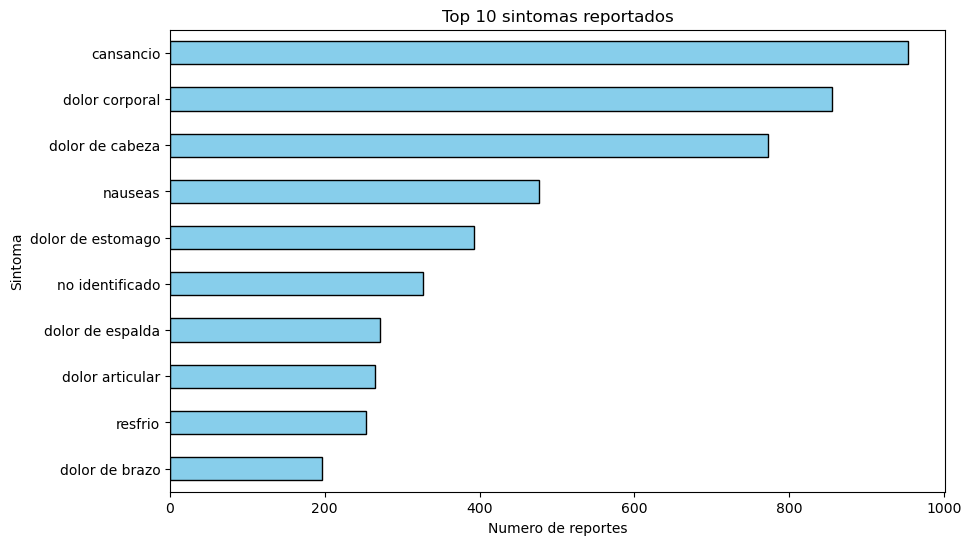

In [7]:
# Cuenta los sintomas
symptom_counts = symptoms_df['description'].value_counts()

# Graficamos el top 10 de mas frecuentes
plt.figure(figsize=(10, 6))
symptom_counts[:10].plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 10 sintomas reportados')
plt.xlabel('Numero de reportes')
plt.ylabel('Sintoma')
plt.gca().invert_yaxis()
plt.show()

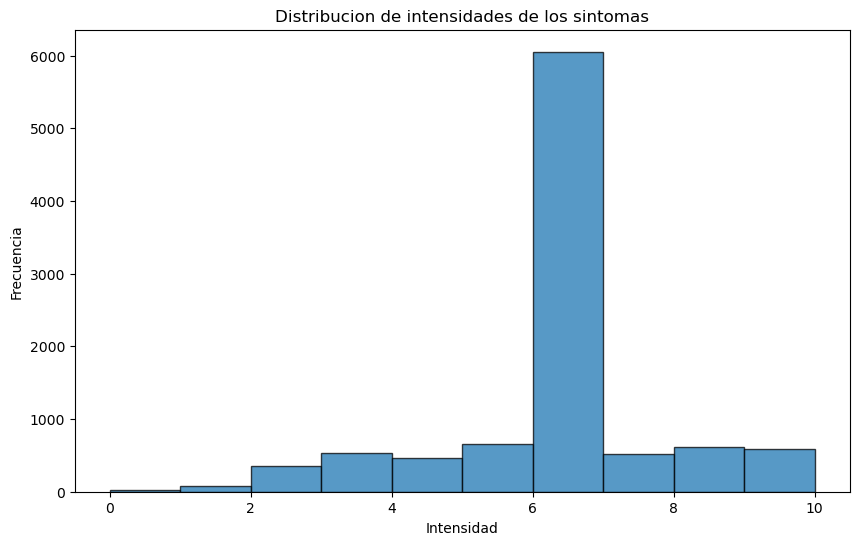

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(symptoms_df['intensity'].dropna(), bins=range(0, 11), alpha=0.75, edgecolor='black')
plt.title('Distribucion de intensidades de los sintomas')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')
plt.show()

In [10]:
# Exportamos los dataset preprocesados en Excel
pipomessage_df.to_excel('Preprocesado/pipomessage.xlsx', index=False)
user_df.to_excel('Preprocesado/user.xlsx', index=False)
usermessage_df.to_excel('Preprocesado/usermessage.xlsx', index=False)
symptoms_df.to_excel('Preprocesado/symptoms.xlsx', index=False)